In [47]:
%matplotlib inline

Supernova Cosmology - Luminosity
------------------

Here we need to use the approximation:
$$
    R_0 \eta = \frac{cz}{H_0}~,
$$
and the equation
$$
    f = \frac{L_{peak}}{4\pi\left[R_0\eta\right]^2(1+z)^2}~,
$$
which can be a pain because our stuff is given in magnitudes, which we can convert using
$$
    m = m_0 - 2.5\log_{10}(f)~.
$$
We will test this with chi squared:
$$
    \chi^2 = \sum_n \frac{(obs_i - exp_i)^2}{\sigma^2}~.
$$

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as si
plt.style.use('bmh')
from scipy.optimize import curve_fit

In [49]:
def magfromflux(f, m0=-13):
    """Gives magnitude from the flux. M0 at the moment is a bit of a mystery to me...
    We'll see how this goes in the future.
    
    Input
    -----
    f: flux in some units
    m0: optional, magnitude for calibration
    
    Output
    ------
    m: Magnitude"""
    
    return m0 - 2.5*np.log10(f)

In [50]:
def reta(z, c=3e08, H0=75*(3.24078e-20)):
    """Gives the R_0 eta value from the equation above. Units still to be sorted.
    
    Input
    -----
    z: redshift
    c: optional, speed of light
    H0: optional, hubble constant
    
    Output
    ------
    reta: R_0 times eta. Useable for the k=0 case."""
    
    return c*z/H0

In [51]:
def fluxfromzlpeak(z, lpeak, reta=reta):
    """Gives the flux as above.
    
    Input
    -----
    z: redshift
    lpeak: peak luminosity, to be fitted
    reta: callable to give r0eta
    
    Output
    ------
    f: flux"""
    
    return lpeak/(4*np.pi*(reta(z)**2)*((1+z)**2))

In [52]:
def magfromzlpeak(z, lpeak, reta=reta):
    """Returns magnitude instead of flux
    
    Input
    -----
    z: redshift
    lpeak: peak luminosity, generally for fitting
    reta: callable to give r0eta
    
    Output
    ------
    m: magnitude"""
    
    return magfromflux(fluxfromzlpeak(z,lpeak,reta))

Now we must fit this equation (fluxfromzlpeak) with the data given for low $z$. We can then get $L_{peak}$. Hopefully.

In [53]:
def readdata(fname="/Users/josh/Documents/superncosmo/data/low_z_data.csv"):
    """Reads data
    
    Input
    -----
    fname: filename for low z data
    
    Output
    ------
    z: z array
    m: magnitude array
    m_err: magnitude error array"""
    
    raw = np.loadtxt(fname, delimiter=" ", usecols=(1,2,3))
    return raw[:,0], raw[:,1], raw[:,2]

In [54]:
def fitdata(z, mag, m_err, fitfunc, p0=(4e30)):
    """Fits the data using curve_fit and prints it nicely. Basically a wrapper for curve_fit"""

    popt, pcov = curve_fit(fitfunc, z, mag, p0, m_err)

    return popt, pcov

In [55]:
def chisq(obs, exp, err):
    """Returns the chi squared as in top writing.
    
    Input
    -----
    obs: observer array
    exp: expected array
    err: error array
    
    Returns
    -------
    csq: Chi Squared"""
    
    csq = 0
    
    for i in range(len(obs)):
        csq = csq + (((obs[i]-exp[i])**2)/(err[i]**2))
        
    return csq

Script below, actually runs and fits data
-----------

Chi Squared: 1.340971
Peak Luminosity in magnitude: -109.234800
Peak Luminosity [  3.11831508e+38] pm [[  2.24657040e+74]]
Note the above numbers are pretty nonsensical, these are just stuff on the way to omega_lambda


/Users/josh/Documents/superncosmo/env/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


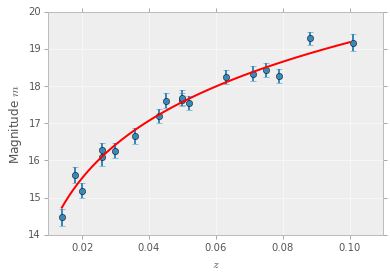

In [62]:
z, mag, m_err = readdata()  # read in data so it can be used

pl, ple = fitdata(z, mag, m_err, magfromzlpeak)

plt.errorbar(z, mag, yerr=m_err, fmt='o')
z_for_fitting = np.arange(min(z), max(z), 0.001)
plt.plot(z_for_fitting, magfromzlpeak(z_for_fitting, pl), color='r')

print("Chi Squared: %f" % (chisq(mag, magfromzlpeak(z, pl), m_err)/(len(z)-2)))  # reduced -- one parameter fitted
print("Peak Luminosity in magnitude: %f" % magfromflux(pl))
print("Peak Luminosity %s pm %s" % (pl, ple))
print("Note the above numbers are pretty nonsensical, these are just stuff on the way to omega_lambda")

plt.xlabel("$z$")
plt.ylabel("Magnitude $m$")
plt.show()

Plotting High-z Data
-------------------

Now we need to take a look at the high redshift data. This is going to be interesting. I'll start by plotting it.

In [57]:
z_high, m_high, m_err_high = readdata("/Users/josh/Documents/superncosmo/data/high_z_data.csv")

Now we need to think about implementing the Friedmann equation. We go from
$$
    \frac{H^2}{H_0^2} = \Omega_M a^{-3} + \Omega_\Lambda + \Omega_k a^{-2}~,
$$
to
$$
    H^2 = H_0^2 \left[(1-\Omega_\Lambda)(1+z)^3 + \Omega_\Lambda\right]~,
$$
in the flat case. We also need a more complex expression for
$$
    R_0\eta = c\int^z_0 \frac{\mathrm{d}z'}{H(z')}~.
$$
In the end this feeds back into the original flux equation given above.

In [58]:
def hinflatu(z, omega_lambda, H0=75*(3.24078e-20)):
    """Implements the equation given before (or rather the inverse square root) so it can be implemented in
    the integral below.
    
    Input
    -----
    z: redshift
    omega_lambda: to be fitted for
    
    Output
    ------
    H(z): hubble parameter at redshift z in a flat universe"""
    
    return 1/(H0*np.sqrt((1-omega_lambda)*((1+z)**3) + omega_lambda))

In [59]:
def rzeroetaint(z, omega_lambda, c=3e08):
    """Implements the above integral and solves it numerically
    
    Input
    -----
    z: redshift
    omega_lambda: to be passed to hinflatu
    
    Output
    ------
    R0eta: integral given above."""
    # issue: quad doens't like arrays
    oarray = np.empty_like(z)
    
    for i in range(len(z)):
        output = si.quad(hinflatu, 0, z[i], args=(omega_lambda))
        oarray[i] = c*output[0]
    
    return oarray

In [60]:
def functiontofitforomegalambda(z, omega_lambda):
    """Function to fit to recover the omega_lambda constant by using m(z) for high z galaxies.
    
    Input
    -----
    z: redshift
    omega_lambda: to be fitted for 
    
    Output
    ------
    m: magnitude to fit with"""
    
    lpeak = pl
    flux = lpeak/(4*np.pi*(rzeroetaint(z, omega_lambda)**2)*((1+z)**2))
    
    return magfromflux(flux)

# Plot of High $z$ Data With Value of $\Omega_\Lambda$

/Users/josh/Documents/superncosmo/env/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


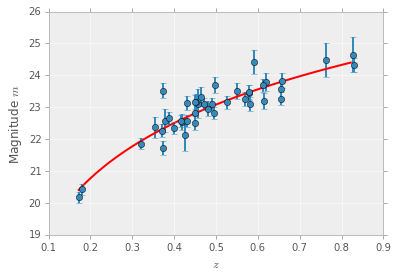

Chi Squared for fit: 2.03327457425
Omega_Lambda = 0.7127 pm 0.004648


In [61]:
popt, pcov = fitdata(np.array(z_high), m_high, m_err_high, functiontofitforomegalambda, p0=(0.5))

#plotting
z_for_plot = np.arange(min(z_high), max(z_high), 0.01)
m_for_plot = functiontofitforomegalambda(z_for_plot, popt)

plt.plot(z_for_plot, m_for_plot, color='r')
plt.errorbar(z_high, m_high, yerr=m_err_high, fmt='o')
plt.xlabel("$z$")
plt.ylabel("Magnitude $m$")
plt.show()

#chisquare
cs = chisq(functiontofitforomegalambda(z_high, popt), m_high, m_err_high)

print("Chi Squared for fit: %s" % (cs/(len(z_high)-2)))  # reduced -- one parameter fitted
print("Omega_Lambda = %1.4f pm %1.6f" % (popt, pcov))